In [11]:
# %matplotlib       # kernel crashes

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal
import scipy.fftpack

# The goal of this notebook is to filter the original signal to obtain a similar cleaned version of the proposed filtered signal.
# Input is a matrix containing sampling rate, raw signal (the one to filter) and filtered signal (the one to get)


dict_keys(['__header__', '__version__', '__globals__', 'fs', 'x', 'y'])
1000


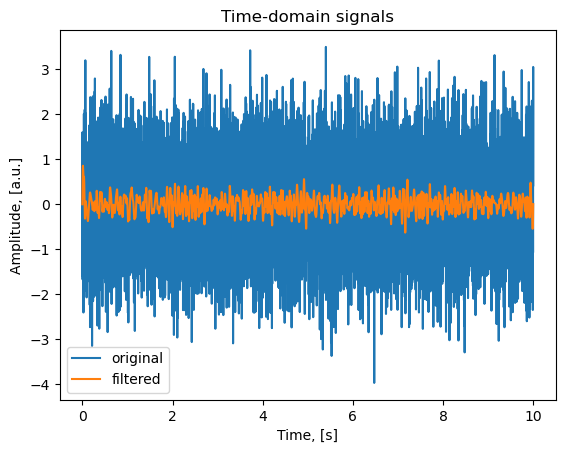

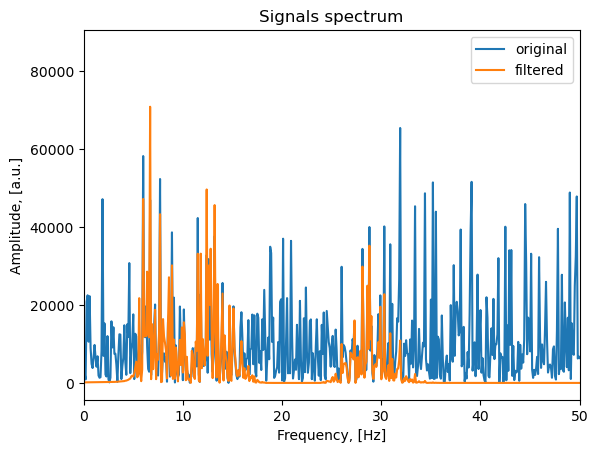

In [12]:
# load original and filtered signals

signalmat = sio.loadmat(r'C:\Users\GIANNI\Desktop\DSP applications on Matlab and Python\Section 5_Filters\sigprocMXC_filtering\filtering_codeChallenge')
print(signalmat.keys())


# define keys
original = signalmat['x'].flatten()
filtered = signalmat['y'].flatten()
fs = int(signalmat['fs'])
tv = np.arange(0, len(original) / fs, 1/fs)
hz = np.linspace(0, fs/2, len(original)//2)   # take only positive frequencies, frequency resolution same as time resolution 
# power spectrum
originalfft = np.abs(scipy.fftpack.fft(original))**2
filteredfft = np.abs(scipy.fftpack.fft(filtered))**2
print(fs)

# plot in time domain
plt.figure()
plt.title('Time-domain signals')
plt.plot(tv, original, label = 'original')
plt.plot(tv, filtered, label = 'filtered')
plt.legend()
plt.xlabel('Time, [s]')
plt.ylabel('Amplitude, [a.u.]')
plt.show()

# plot in frequency
plt.figure()
plt.title('Signals spectrum')
plt.plot(hz, originalfft[:len(hz)], label = 'original') # plot only positive frequencies
plt.plot(hz, filteredfft[:len(hz)], label = 'filtered')
plt.xlim([0, 50])
plt.legend()
plt.xlabel('Frequency, [Hz]')
plt.ylabel('Amplitude, [a.u.]')
plt.show()



469.0


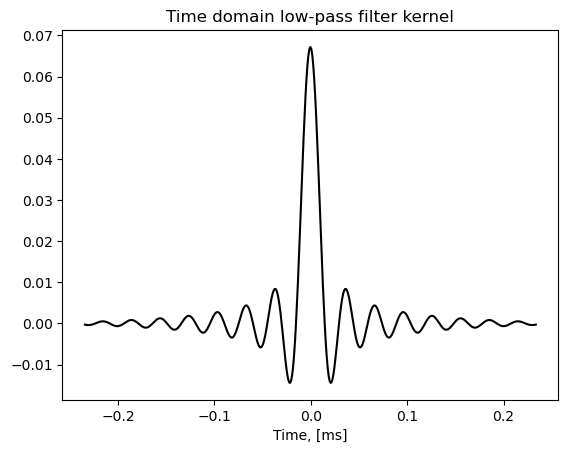

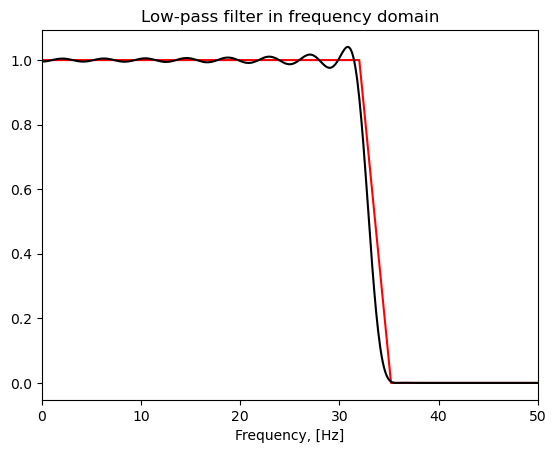

In [13]:
# I would start by applying a low pass filter at 33 Hz, followed by a Notch between 18 and 26 Hz, followed by a high-pass with cutoff = 5 Hz

# LOW-PASS FILTER
fcut = 32 
slope = .1 
order = np.round( 15*fs/fcut )

if order%2 == 0:
    order += 1   # order must be odd
print(order)

shape = [1, 1, 0, 0]
freq_vec = [0, fcut, fcut + slope * fcut, fs/2]

kernel = scipy.signal.firls(order, freq_vec, shape, fs = fs)
kernel_spectrum = np.abs(scipy.fftpack.fft(kernel, len(tv)))**2

# plot the filter kernel in time domain
plt.figure()
plt.title('Time domain low-pass filter kernel')
plt.plot(np.arange(-order/2, order/2)/fs, kernel, 'k' )
plt.xlabel('Time, [ms]')
plt.show()

# plot the ideal vs actual filter in frequency domain
plt.figure()
plt.title('Low-pass filter in frequency domain')
plt.plot(np.array(freq_vec), shape, 'r')
plt.plot(hz, kernel_spectrum[:len(hz)], 'k')
plt.xlabel('Frequency, [Hz]')
plt.xlim([0, 50])
plt.show()



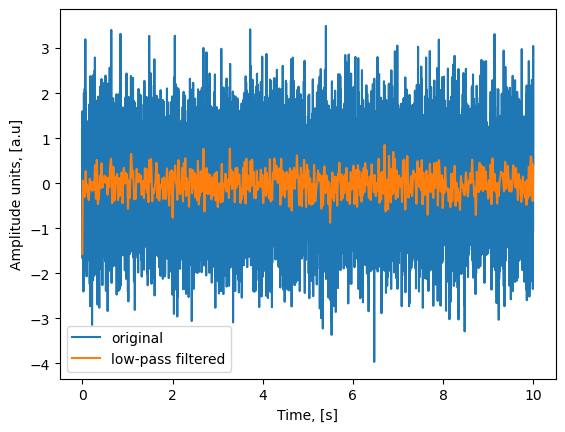

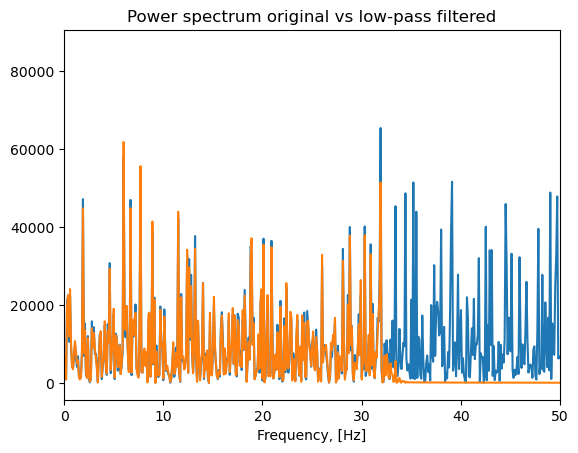

In [14]:
# now let's apply the filter to the data

yfilt = scipy.signal.filtfilt(kernel, 1, original)

plt.plot(tv, original, label = 'original')
plt.plot(tv, yfilt, label = 'low-pass filtered')
plt.legend()
plt.xlabel('Time, [s]')
plt.ylabel('Amplitude units, [a.u]')
plt.show()

# now in frequency domain
yfilt_spectra = np.abs(scipy.fftpack.fft(yfilt, len(tv)))**2  # always remember to specify the numer of points according to the number of points of the signal in time domain

plt.figure()
plt.title('Power spectrum original vs low-pass filtered')
plt.plot(hz, originalfft[:len(hz)], label = 'original')
plt.plot(hz, yfilt_spectra[:len(hz)], label = 'low-pass filtered')
plt.xlabel('Frequency, [Hz]')
plt.xlim([0, 50])
plt.show()


841.0


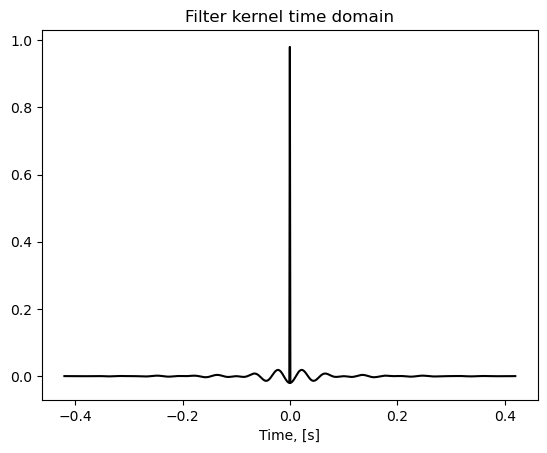

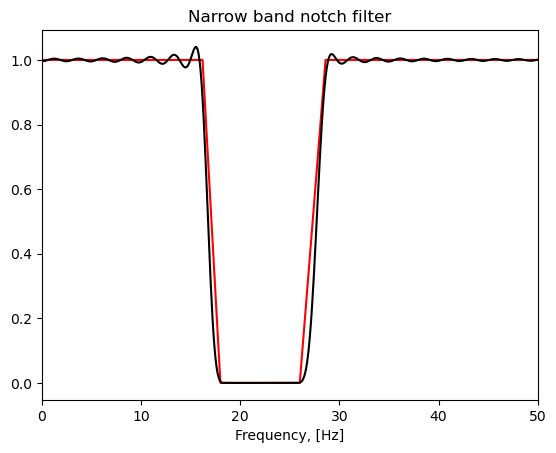

In [15]:
# now I try applying a Notch to eliminate frequencies in range [18,26] Hz

# Narrow-band notch filter design

band = [18,26]
order = 15*np.round(fs/band[0]) + 1 
slope = .1

if order%2 == 0:
    order +=1    # order must be odd

print(order)

shape = [1, 1, 0, 0, 1, 1]
frex = [0, band[0] - slope*band[0], band[0], band[1], band[1] + band[1]*slope, fs/2]

filtkern = scipy.signal.firls(order, frex, shape, fs = fs)

# plot filter kernel
plt.figure()
plt.title('Filter kernel time domain')
plt.plot(np.arange(-order/2, order/2)/fs, filtkern, 'k')
plt.xlabel('Time, [s]')
plt.show()

# power spectrum
notchspectra = np.abs(scipy.fftpack.fft(filtkern, len(tv)))**2

plt.figure()
plt.title('Narrow band notch filter')
plt.plot(np.array(frex), shape, 'r')
plt.plot(hz, notchspectra[:len(hz)], 'k')
plt.xlabel('Frequency, [Hz]')
plt.xlim([0, 50])
plt.show()

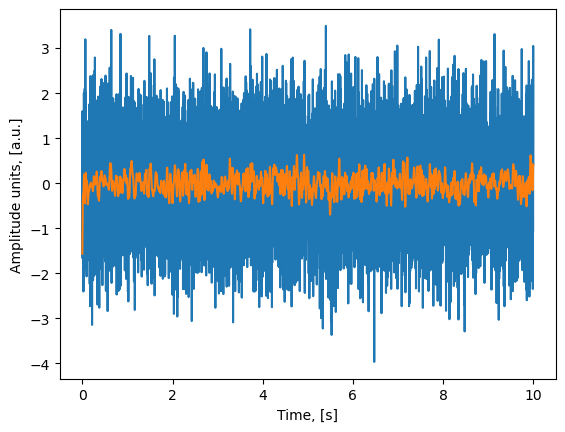

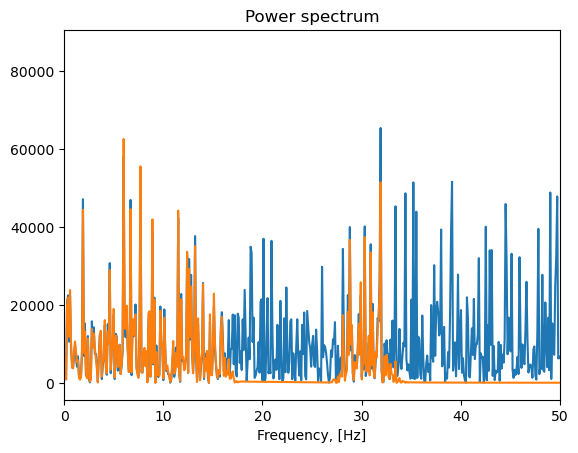

In [16]:
# now let's apply filter to data

yfiltfilt = scipy.signal.filtfilt(filtkern, 1, yfilt)

plt.figure()
plt.plot(tv, original, label = 'original')
plt.plot(tv, yfiltfilt, label = 'low-pass + notch filtered')
plt.xlabel('Time, [s]')
plt.ylabel('Amplitude units, [a.u.]')
plt.show()

# now power spectrum
yfiltfiltspectra = np.abs(scipy.fftpack.fft(yfiltfilt, len(tv)))**2

plt.figure()
plt.title('Power spectrum')
plt.plot(hz, originalfft[:len(hz)])
plt.plot(hz, yfiltfiltspectra[:len(hz)])
plt.xlim([0,50])
plt.xlabel('Frequency, [Hz]')
plt.show()

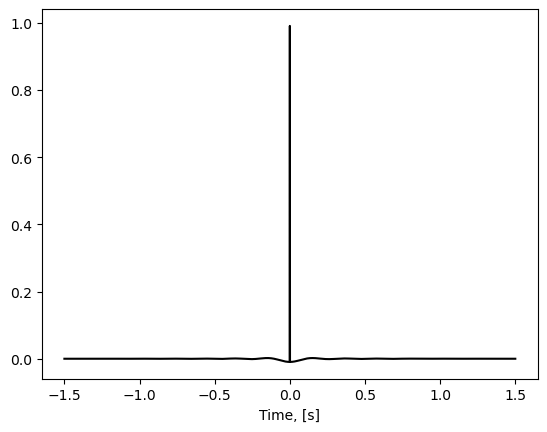

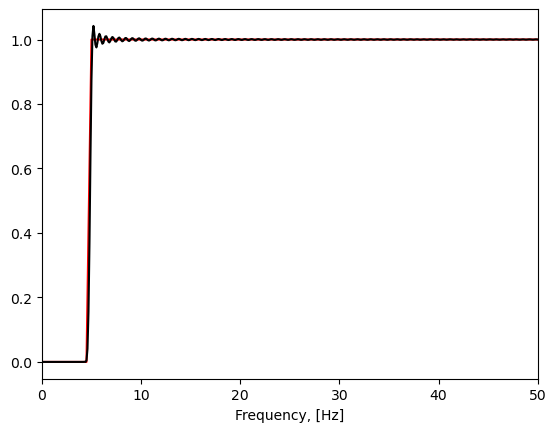

In [17]:
# Finally, let's apply a high-pass filter and we are done!

fcutoff = 5
transw = .1
order = 15*np.round(fs/fcutoff) +1 

if order/2 == 0:
    order +=1     # order must be odd

shape = [0,0,1,1]
frex_vec = [0, fcutoff - transw*fcutoff, fcutoff, fs/2]

hpkernel = scipy.signal.firls(order, frex_vec, shape, fs = fs)

plt.figure()
plt.plot(np.arange(-order/2, order/2)/fs, hpkernel, 'k')
plt.xlabel('Time, [s]')
plt.show()

# power spectrum

hpspectra = np.abs(scipy.fftpack.fft(hpkernel, len(tv)))**2

plt.figure()
plt.plot(np.array(frex_vec), shape, 'r')
plt.plot(hz, hpspectra[:len(hz)], 'k')
plt.xlabel('Frequency, [Hz]')
plt.xlim([0, 50])
plt.show()

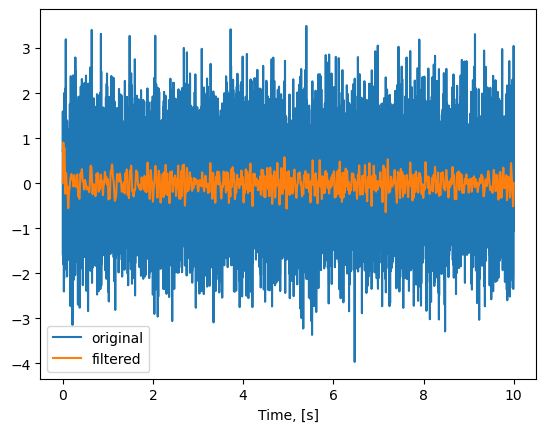

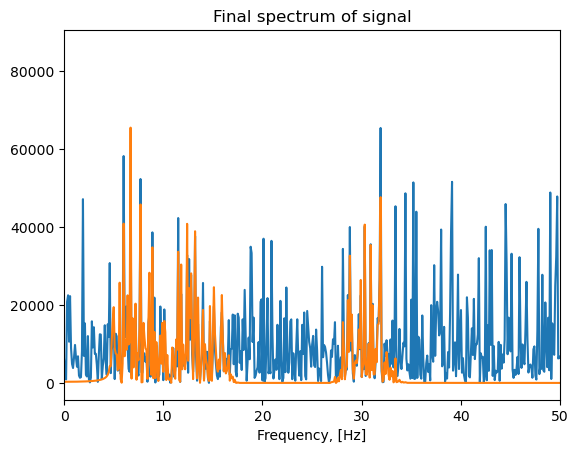

In [10]:
# let's apply filter to the data

yfinal = scipy.signal.filtfilt(hpkernel, 1, yfiltfilt)

plt.figure()
plt.plot(tv, original, label = 'original')
plt.plot(tv, yfinal, label = 'filtered')
plt.xlabel('Time, [s]')
plt.legend()
plt.show()

yfinalspectra = np.abs(scipy.fftpack.fft(yfinal, len(tv)))**2

plt.figure()
plt.title('Final spectrum of signal')
plt.plot(hz, originalfft[:len(hz)], label = 'original')
plt.plot(hz, yfinalspectra[:len(hz)], label = 'filtered')
plt.xlabel('Frequency, [Hz]')
plt.xlim([0,50])
plt.show()